# Imports

In [32]:
# Torch
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

# Wandb
import wandb

# Python
import random as rand

# Numpy
import numpy as np

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Seeding
torch.manual_seed(24)

# Scheduler
from torch.optim.lr_scheduler import StepLR

# GPU/CPU

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
# Get device
device = get_default_device()

In [35]:
device

device(type='cuda')

# WANDB

In [5]:
# Define sweep
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'validation_loss',
      'goal': 'minimize'
    },
    'early_terminate': {
        'type': 'hyperband',
        'min_iter': 3
    },
    'parameters': {
        'epochs': {
            'values': [140, 160, 180]
        },
        'step_size': {
            'values': [40, 50, 60]
        },
        'gamma': {
            'values': [0.5, 0.1]
        },
        'pool1': {
            'values': ['max', 'avg']
        },
        'pool2': {
            'values': ['max', 'avg']
        },
        'pool3': {
            'values': ['max', 'avg']
        }
    }
}

# Datasets

### Load

In [6]:
# Transform
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load train and test set
trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Labels
CLASSES = trainset.classes

In [8]:
CLASSES

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Dataset related parameters

In [9]:
# Params
batch_size = 4000
val_size = 5000
train_size = len(trainset) - val_size

### Preparation

In [10]:
# Create train and validation
trainset, validationset = torch.utils.data.random_split(trainset, [train_size, val_size])

In [11]:
print("Validation set lenght: ", len(validationset))
print("Train set length: ", len(trainset))

Validation set lenght:  5000
Train set length:  45000


In [12]:
# Create dataloaders
test_loader = torch.utils.data.DataLoader(testset, batch_size, num_workers=4, pin_memory=True)
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(validationset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [13]:
# Move dataloader to device
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
train_loader = DeviceDataLoader(train_loader, device)

# Model

### Helper Functions

In [14]:
# Accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Evaluation
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Training
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 60,
        'step_size': 5,
        'gamma': 0.5,
        'pool1': 'max',
        'pool2': 'max',
        'pool3': 'max'
    }
    
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config
    config = wandb.config

    # Model
    model = to_device(CIFAR10Model(config), device)
    model.train()
    
    # SGD optimizer
    optimizer = torch.optim.SGD(model.parameters(), 0.01, momentum=0.9)
    
    # gamma = decaying factor
    scheduler = StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    
    for epoch in range(config.epochs):        
        # Cumulative loss
        closs = 0
        
        # Training Phase 
        for batch_idx, batch in enumerate(train_loader):
            # Feed forward
            loss = model.training_step(batch)
            
            # Compute gradient
            loss.backward()
            
            # Add loss to cumulative
            closs += loss.item()
            
            # Backprop
            optimizer.step()
            
            # Clean gradients
            optimizer.zero_grad()
            
            # Log wandb (batch loss)
            wandb.log({"batch_loss": loss.item()})
                
        # Adaptive learning
        scheduler.step()
        
        # Log epoch loss (train)
        wandb.log({"train_loss": closs/len(train_loader)})
        
        # Log validation loss
        wandb.log({"validation_loss":evaluate(model, val_loader)['val_loss']})

        # Log validation accuracy
        wandb.log({"validation_accuracy":evaluate(model, val_loader)['val_acc']})
    
    # Save model
    print("SAVING NOW")
    torch.save(model, f"model_{config.epochs}_{config.step_size}_{config.gamma}.th")

### Model Class

In [15]:
class CIFAR10Model(nn.Module):
    def __init__(self, config):
        # Init
        super().__init__()
        
        # Convolution layer
        self.conv_layer1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) if config.pool1 == 'max' else nn.AvgPool2d(kernel_size=2, stride=2),

        )
        self.conv_layer2 = nn.Sequential(
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) if config.pool2 == 'max' else nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

        )
        self.conv_layer3 = nn.Sequential(

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) if config.pool3 == 'max' else nn.AvgPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def conv1(self,x):
        return self.conv_layer1(x)
    
    def conv2(self,x):
        x = self.conv_layer1(x)
        return self.conv_layer2(x)
    
    def conv3(self,x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        return self.conv_layer3(x)
        
    def forward(self, x):
        # conv layers
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x
    

    def training_step(self, batch):
        # Unpack batch
        images, labels = batch
        
        # Run forward pass
        out = self.forward(images)
        
        # Compute and return loss
        return nn.CrossEntropyLoss()(out, labels)
    
    def validation_step(self, batch):
        # Unpack batch
        images, labels = batch
        
        # Run forward pass
        out = self.forward(images)
        
        # Compute loss
        loss = nn.CrossEntropyLoss()(out, labels)
        
        # Compute accuracy
        acc = accuracy(out, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# Training

In [16]:
# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="Assignment-4")

Create sweep with ID: 4ea83hc3
Sweep URL: https://wandb.ai/itaouil/Assignment-4/sweeps/4ea83hc3


In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: 1ogkw9lv with config:
wandb: 	epochs: 180
wandb: 	gamma: 0.5
wandb: 	pool1: max
wandb: 	pool2: avg
wandb: 	pool3: avg
wandb: 	step_size: 50
wandb: Currently logged in as: itaouil (use `wandb login --relogin` to force relogin)


SAVING NOW


batch_loss,0.69092
_step,2699
_runtime,1331
_timestamp,1607681355
train_loss,0.39922
validation_loss,1.98596
validation_accuracy,0.6


batch_loss,████▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,████▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
validation_loss,████▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▆
validation_accuracy,▁▁▂▂▃▄▄▅▅▅▆▆▇▆▇▇▇▇▇▇▇██████████████████▇


wandb: Agent Starting Run: rwtabqnj with config:
wandb: 	epochs: 140
wandb: 	gamma: 0.1
wandb: 	pool1: avg
wandb: 	pool2: max
wandb: 	pool3: max
wandb: 	step_size: 60


SAVING NOW


batch_loss,0.53561
_step,2099
_runtime,1036
_timestamp,1607682395
train_loss,0.56245
validation_loss,0.93063
validation_accuracy,0.693


batch_loss,█████▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,████▇▇▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,████▇▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▂▂▃▃▄▄▅▅▆▆▆▆▆▇▇███████████████████████


wandb: Agent Starting Run: 36ygowww with config:
wandb: 	epochs: 180
wandb: 	gamma: 0.1
wandb: 	pool1: max
wandb: 	pool2: avg
wandb: 	pool3: max
wandb: 	step_size: 60


SAVING NOW


batch_loss,0.53032
_step,2699
_runtime,1334
_timestamp,1607683735
train_loss,0.50926
validation_loss,0.84933
validation_accuracy,0.71575


batch_loss,███▆▆▅▅▄▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,███▇▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,███▆▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▂▂▃▄▅▅▅▆▆▆▇▇▇██████████████████████████


wandb: Agent Starting Run: ssnjv7wp with config:
wandb: 	epochs: 180
wandb: 	gamma: 0.5
wandb: 	pool1: avg
wandb: 	pool2: avg
wandb: 	pool3: max
wandb: 	step_size: 50


SAVING NOW


batch_loss,0.00257
_step,2699
_runtime,1336
_timestamp,1607685077
train_loss,0.00261
validation_loss,3.19053
validation_accuracy,0.61513


batch_loss,███▇█▇▇▆▆▅▅▅▅▄▅▄▄▄▄▃▄▃▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,███▇█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▅▅▅▄▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▂▃▂▃▄▅▅▆▇▇▇█▇████
validation_accuracy,▁▁▂▃▂▃▄▄▅▆▆▆▇▇▇▇▇█▇█████████████████████


wandb: Agent Starting Run: 9kfsest0 with config:
wandb: 	epochs: 180
wandb: 	gamma: 0.1
wandb: 	pool1: max
wandb: 	pool2: avg
wandb: 	pool3: max
wandb: 	step_size: 60


SAVING NOW


batch_loss,0.59463
_step,2699
_runtime,1334
_timestamp,1607686416
train_loss,0.61687
validation_loss,0.88647
validation_accuracy,0.70575


batch_loss,███▇▆▅▅▄▄▄▄▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,████▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▇▇▇▇█▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▂▂▂▄▅▅▆▆▆▇▇▇██████████████████████████


wandb: Agent Starting Run: lymqjr9w with config:
wandb: 	epochs: 160
wandb: 	gamma: 0.1
wandb: 	pool1: avg
wandb: 	pool2: avg
wandb: 	pool3: avg
wandb: 	step_size: 60


# AVG or MAX

<img src="./comparison.png">

### Load Best Model

In [28]:
the_model = torch.load("model_180_60_0.1.th")

# Visualize Kernels

torch.Size([32, 3, 3, 3])


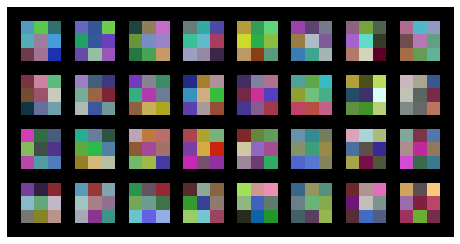

torch.Size([64, 32, 3, 3])


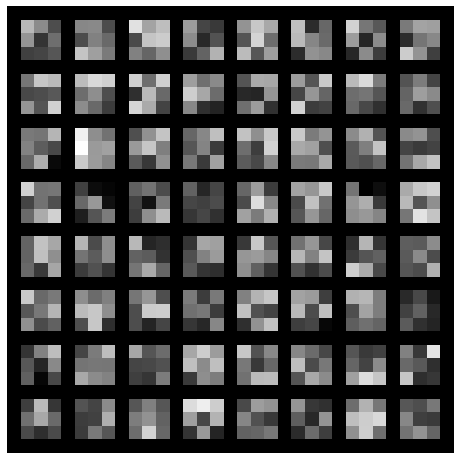

torch.Size([128, 64, 3, 3])


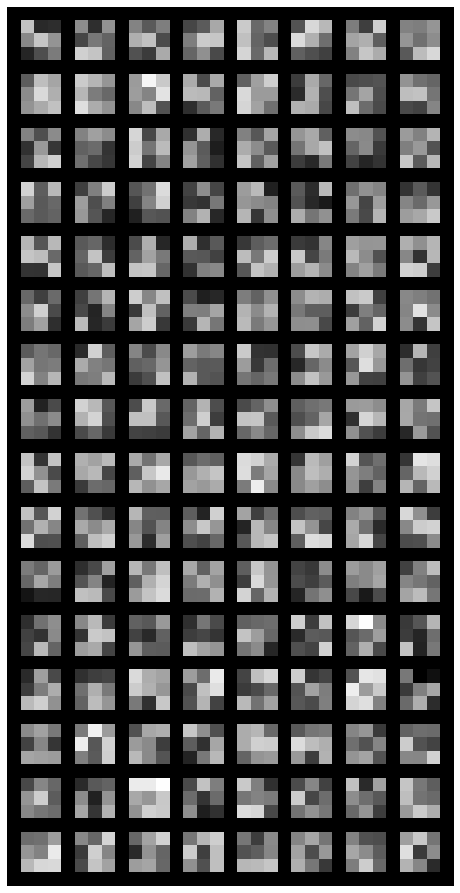

torch.Size([128, 128, 3, 3])


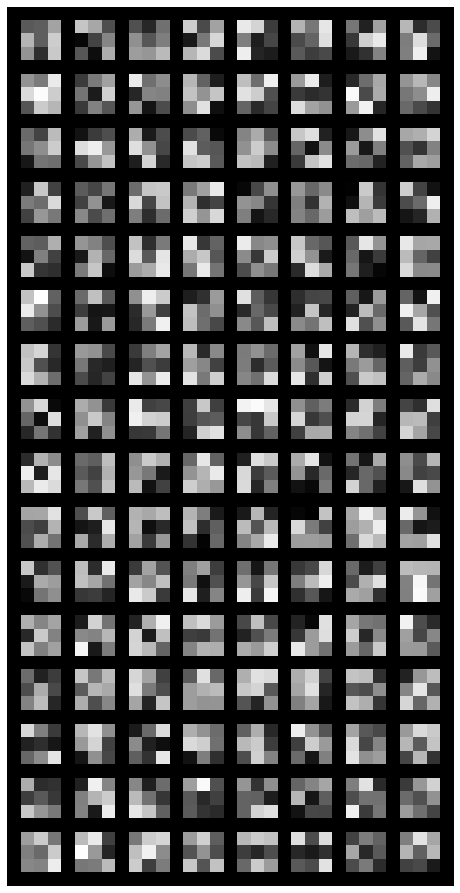

torch.Size([256, 128, 3, 3])


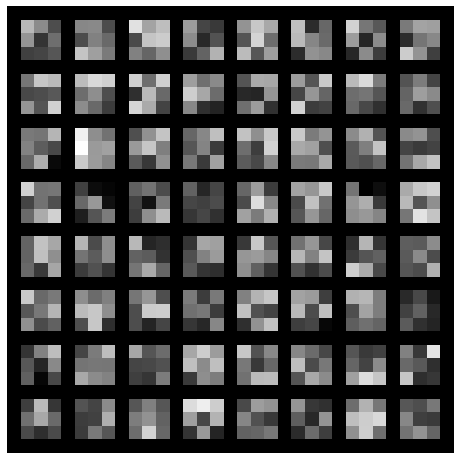

torch.Size([256, 256, 3, 3])


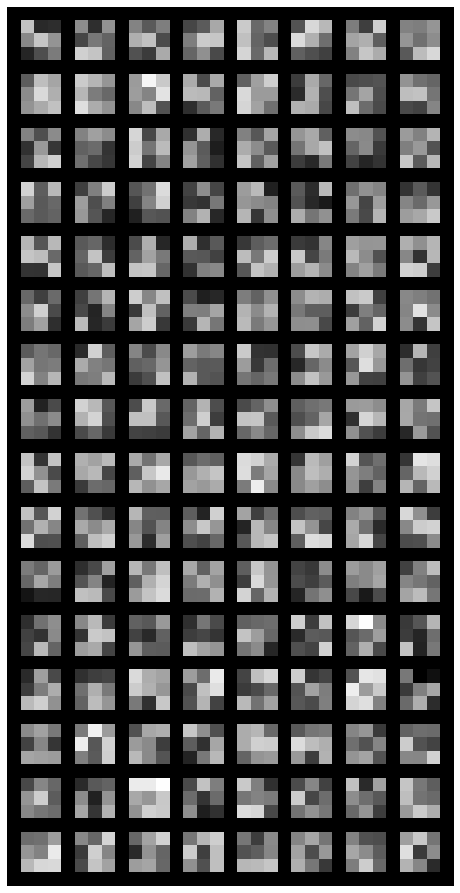

In [29]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
def vistensor(tensor, ch=0, nrow=8,allkernels=False, padding=1): 
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min((tensor.shape[0]//nrow + 1, 64 ) )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow,rows) )
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))

conv_layers = [i for i in the_model.children()]

conv1_out = conv_layers[0][0].weight.data.clone()
print(conv1_out.shape)
vistensor(conv1_out)
plt.axis('off')
plt.ioff()
plt.show()

conv2_out = conv_layers[0][3].weight.data.clone()
print(conv2_out.shape)
vistensor(conv2_out)
plt.axis('off')
plt.ioff()
plt.show()

conv3_out = conv_layers[1][0].weight.data.clone()
print(conv3_out.shape)
vistensor(conv3_out)
plt.axis('off')
plt.ioff()
plt.show()

conv4_out = conv_layers[1][3].weight.data.clone()
print(conv4_out.shape)
vistensor(conv4_out)
plt.axis('off')
plt.ioff()
plt.show()

conv5_out = conv_layers[2][0].weight.data.clone()
print(conv5_out.shape)
vistensor(conv2_out)
plt.axis('off')
plt.ioff()
plt.show()

conv6_out = conv_layers[2][3].weight.data.clone()
print(conv6_out.shape)
vistensor(conv3_out)
plt.axis('off')
plt.ioff()
plt.show()

#weight2 = conv2.weight.data.numpy()
#plt.imshow(weight2[0, ...])

# Visualize Activations

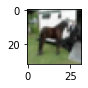

In [30]:
image = testset[20]
vistensor(image[0].view(1,image[0].shape[0],image[0].shape[1],image[0].shape[2]))
#plt.show()
#image

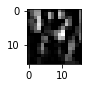

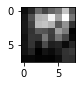

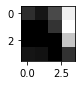

In [46]:
out1 = the_model.conv1(image[0].view(1,image[0].shape[0],image[0].shape[1],image[0].shape[2]).to(device))
vistensor(out1.detach())

out2 = the_model.conv2(image[0].view(1,image[0].shape[0],image[0].shape[1],image[0].shape[2]).to(device))
vistensor(out2.detach())

out3 = the_model.conv3(image[0].view(1,image[0].shape[0],image[0].shape[1],image[0].shape[2]).to(device))
vistensor(out3.detach())

#plot_img(out.detach())